In [1]:
using Base: @kwdef
#using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, PyPlot, ProgressMeter
#using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter
#using BenchmarkTools; @btime
using DSP
rc("axes.spines", top=false, right=false)

In [2]:
function isi_neuron(dt, T; n_neurons=10, fr=2)
    # dt, T: sec
    nt = round(Int, T/dt) # number of timesteps    
    spikes = rand(nt, n_neurons) .< fr*dt #*1e-3
    return 1.0*spikes
end

isi_neuron (generic function with 1 method)

In [3]:
n_neurons_exc = 800*2
n_neurons_inh = 200*2
dt = 1e-4 # sec
T = 10
spikes_exc = isi_neuron(dt, T, n_neurons=n_neurons_exc, fr=2);
spikes_inh = isi_neuron(dt, T, n_neurons=n_neurons_inh, fr=5);

In [4]:
# 二重指数関数型シナプス
function double_exp_synapse(spikes, dt, T; tr=1e-4, td=2e-3)
    nt, n_neurons = size(spikes)
    r_double, hr = zero(spikes), zero(spikes)
    for t in 1:nt-1
        r_double[t+1, :] = r_double[t, :]*(1-dt/tr) + hr[t, :]*dt
        hr[t+1, :] = hr[t, :]*(1-dt/td) + spikes[t, :]/(tr*td)
    end
    return r_double
end

double_exp_synapse (generic function with 1 method)

In [5]:
r_exc = double_exp_synapse(spikes_exc, dt, T, tr=1e-4, td=2e-3);
r_inh = double_exp_synapse(spikes_inh, dt, T, tr=5e-4, td=1e-2);

In [6]:
g_exc = sum(r_exc, dims=2);
g_inh = sum(r_inh, dims=2);

In [7]:
ei_ratio = sum(g_exc) / sum(g_inh)

1.599731898203886

In [8]:
v_rest = -65
v_rev_exc = 0
v_rev_inh = -80

-80

In [14]:
lfps = []
for target_ei_ratio in 2:8
    alpha_inh = target_ei_ratio * ei_ratio
    lfp = ((v_rest - v_rev_exc) * g_exc + (v_rest - v_rev_inh) * alpha_inh * g_inh) / (n_neurons_exc+n_neurons_inh);
    push!(lfps, lfp)
end

In [17]:
fs = 1/dt
psd_lfps = [DSP.Periodograms.welch_pgram(vec(lpf), fs=fs) for lpf in lfps];

In [21]:
cm = get_cmap(:viridis)

In [22]:
cm

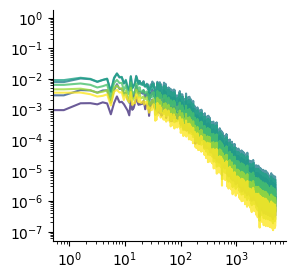

In [28]:
figure(figsize=(3,3))
for (i, psd) in enumerate(psd_lfps)
    loglog(psd.freq, (psd.power/sum(psd.power)), alpha=0.8, color=cm(i/7))
end
#xlim(1, 100)
#ylim(2e-4, 5e-2)